# Import Libreries

In [1]:
import pandas as pd 
import numpy as np 

import os
import cv2
from pathlib import Path

from IPython.display import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, losses, metrics

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.13.1


# Data Path Variables

In [2]:
with_mask_dir_s = Path('../PREPARE_DATA/with_mask/simple/')
with_mask_dir_c = Path('../PREPARE_DATA/with_mask/complex/')

without_mask_dir_s = Path('../PREPARE_DATA/without_mask/simple/')
without_mask_dir_c = Path('../PREPARE_DATA/without_mask/complex/')

mc_dir = Path('../PREPARE_DATA/incorrect_mask/mc/')
mmc_dir = Path('../PREPARE_DATA/incorrect_mask/mmc/')

In [3]:
with_mask_dir_s.glob(r'*jpg')
with_mask_dir_c.glob(r'*jpg')

without_mask_dir_s.glob(r'*jpg')
without_mask_dir_c.glob(r'*jpg')

mc_dir.glob(r'*jpg')
mmc_dir.glob(r'*jpg')

<generator object Path.glob at 0x000001F0E86C2570>

### Funtion to create dataframe for data

In [4]:
def generate_df(image_dir, label):
    filepath = pd.Series(list(image_dir.glob(r'*jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepath.index).astype(str)
    df = pd.concat([filepath, labels], axis=1)
    return df

### Merge all the dataframes into into one Dataframe

In [5]:
labels = {0:"With Mask", 1:"without Mask", 2:"Incorrect Mask"}

with_mask_df_s = generate_df(with_mask_dir_s, label=0)
with_mask_df_c = generate_df(with_mask_dir_c, label=0)

without_mask_df_s = generate_df(without_mask_dir_s, label=1)
without_mask_df_c = generate_df(without_mask_dir_c, label=1)

mc_df = generate_df(mc_dir, label=2)
mmc_df = generate_df(mmc_dir, label=2)

total_df = pd.concat([with_mask_df_s, with_mask_df_c, without_mask_df_s, without_mask_df_c, mc_df, mmc_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
total_df.head()

,Filepath,Label
0,..\PREPARE_DATA\without_mask\simple\simple23_0...,1
1,..\PREPARE_DATA\without_mask\simple\simple1183...,1
2,..\PREPARE_DATA\incorrect_mask\mc\2486_0.jpg,2
3,..\PREPARE_DATA\with_mask\simple\simple566_0.jpg,0
4,..\PREPARE_DATA\incorrect_mask\mmc\1277_0.jpg,2


In [6]:
total_df.shape

(16349, 2)

In [7]:
total_df.Label.value_counts()

Label
1    6367
2    5061
0    4921
Name: count, dtype: int64

# Data Spiliting

In [8]:
train_df, test_df = train_test_split(total_df, train_size=0.8, shuffle=True, random_state=1)

# Loading Data

In [9]:

train_gen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.2,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_gen = ImageDataGenerator(
      rescale=1./255,
)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 10464 validated image filenames belonging to 3 classes.
Found 2615 validated image filenames belonging to 3 classes.
Found 3270 validated image filenames belonging to 3 classes.


# Ploting Data

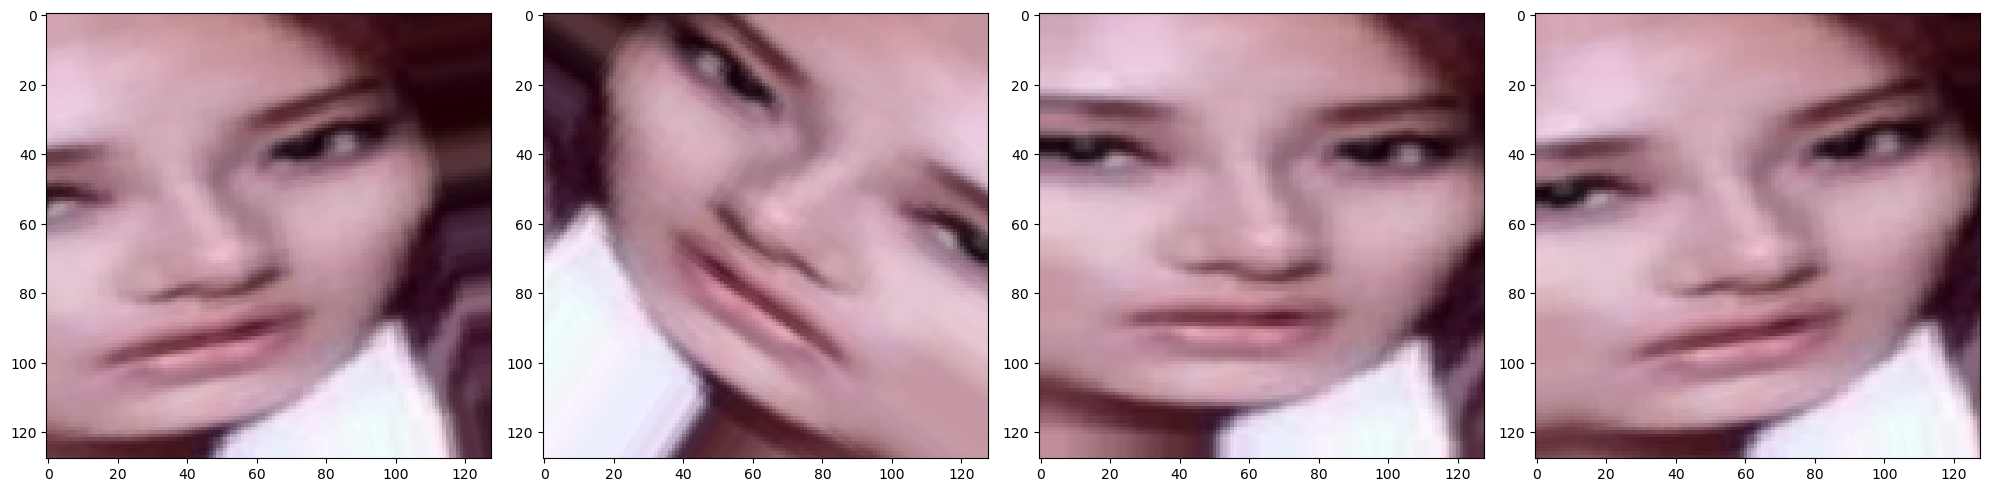

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_data[0][0][31] for i in range(4)]
plotImages(augmented_images)

# CNN Model

In [11]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
            
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(3, activation='softmax'))

    return model

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

### Model Compiler(with `Adam` optimizer, `categorical_crossentropy` loss, and `accuracy` matrics)

In [13]:
model.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Model Train

In [14]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
327/327 [==============================] - 104s 315ms/step - loss: 0.4413 - accuracy: 0.8299 - val_loss: 0.3507 - val_accuracy: 0.8914
Epoch 2/10
327/327 [==============================] - 95s 291ms/step - loss: 0.2939 - accuracy: 0.9010 - val_loss: 0.2256 - val_accuracy: 0.9277
Epoch 3/10
327/327 [==============================] - 106s 324ms/step - loss: 0.2433 - accuracy: 0.9221 - val_loss: 0.1933 - val_accuracy: 0.9403
Epoch 4/10
327/327 [==============================] - 101s 309ms/step - loss: 0.2039 - accuracy: 0.9370 - val_loss: 0.1806 - val_accuracy: 0.9358
Epoch 5/10
327/327 [==============================] - 94s 288ms/step - loss: 0.1940 - accuracy: 0.9399 - val_loss: 0.1623 - val_accuracy: 0.9461
Epoch 6/10
327/327 [==============================] - 110s 336ms/step - loss: 0.1833 - accuracy: 0.9417 - val_loss: 0.1609 - val_accuracy: 0.9491
Epoch 7/10
327/327 [==============================] - 97s 295ms/step - loss: 0.1775 - accuracy: 0.9433 - val_loss: 0.1559 - va

# Ploting the graph of loss and Accuracy

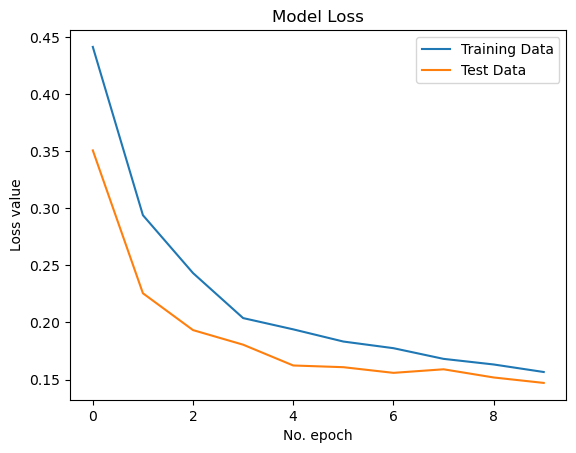

In [15]:
plt.plot(history.history['loss'], label='Training Data')
plt.plot(history.history['val_loss'], label='Test Data')
plt.title("Model Loss")
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

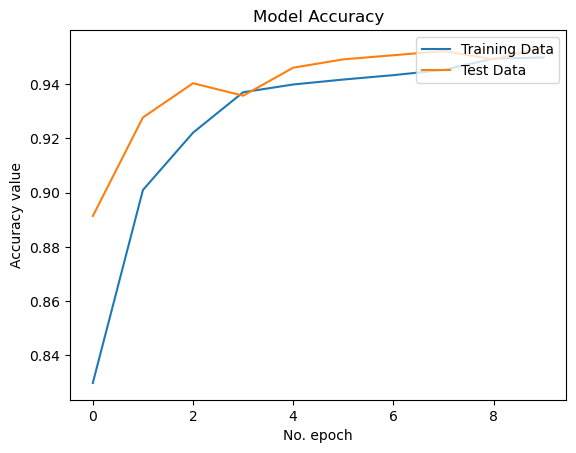

In [16]:
plt.plot(history.history['accuracy'], label='Training Data')
plt.plot(history.history['val_accuracy'], label='Test Data')
plt.title("Model Accuracy")
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

# Predictions and Testing

### Label
- 0: With Mask
- 1: Without Mask
- 2: Incorrect Mask

In [17]:
# Model Accuracy and loss
loss, accuracy = model.evaluate(test_data)

103/103 [==============================] - 12s 120ms/step - loss: 0.1212 - accuracy: 0.9615


In [18]:
print(f"""Model Evalution:
Loss: {loss}
Accuracy: {accuracy}""")

Model Evalution:
Loss: 0.12122797220945358
Accuracy: 0.9614678621292114


In [20]:
# Original Labels
y_true = test_data.labels
print("Size of true labels: ", len(y_true))

Size of true labels:  3270


In [21]:
# Prediction Labels
y_pred = model.predict(test_data)

103/103 [==============================] - 6s 62ms/step


In [22]:
y_pred = np.argmax(y_pred, axis=-1)
print("Size of predicted Labels: ", y_pred.shape[0])

Size of predicted Labels:  3270


# Confusion Matrics

In [23]:
# Confusion Matrics
confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

array([[ 961,   33,    8],
       [  31, 1207,    8],
       [  22,   24,  976]], dtype=int64)

# Single Predictions

In [24]:
def resize_image_keep_aspect_ratio(image, target_width, target_height, fill_color=(255, 255, 255)):
    """
    Resize an image while keeping its aspect ratio and filling the remaining area with a specified color.
    
    Args:
        image (numpy.ndarray): The input image.
        target_width (int): The target width of the resized image.
        target_height (int): The target height of the resized image.
        fill_color (tuple): The color to fill the remaining area with. Default is white (255, 255, 255).
    
    Returns:
        numpy.ndarray: The resized image.
    """
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Get the original image dimensions
    height, width = image.shape[:2]
    
    # Calculate the aspect ratios
    aspect_ratio = width / height
    target_aspect_ratio = target_width / target_height
    
    # Compute the resizing dimensions while keeping the aspect ratio
    if aspect_ratio > target_aspect_ratio:
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(new_height * aspect_ratio)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))
    
    # Create a new canvas with the target dimensions and fill it with the specified color
    canvas = np.full((target_height, target_width, 3), fill_color, dtype=np.uint8)
    
    # Compute the position to paste the resized image while centering it
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    
    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image
    
    return canvas

In [25]:
def predict(image_path, model=model):
    image = cv2.imread(image_path)
    image = resize_image_keep_aspect_ratio(image, 128, 128)
    image = image/255.0
    image = np.expand_dims(image, axis=0)
    pred = model.predict(image)
    pred = np.argmax(pred)
    label = labels[pred]
    return label



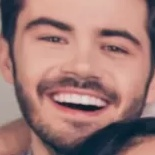

In [26]:
from IPython.display import Image
img_path = "../tmp/face1.jpg"
Image(img_path)

In [27]:
predict(img_path)

1/1 [==============================] - 0s 48ms/step


'without Mask'

# Model save

In [28]:
model.save("../Models/mask_detection_128.keras")